### 變數定義

- \(S\): 當前資產價格（Current Stock Price）
- \(K\): 行使價格（Strike Price）
- \(r\): 無風險利率（Risk-free Rate）
- \(sigma\): 資產的波動率（Volatility）
- \(T\): 到期時間（以年為單位，Time to Maturity）


In [4]:
import numpy as np
from scipy.stats import norm, poisson
import matplotlib.pyplot as plt
import pandas as pd
import chardet

class ConvertibleBondPricer:
    
    def __init__(self, S, K, T, r, sigma, conversion_ratio, credit_spread, trigger_price):
        self.S = S
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.conversion_ratio = conversion_ratio
        self.credit_spread = credit_spread
        self.trigger_price = trigger_price

    def black_scholes_price(self):
        """
        使用Black-Scholes模型定價
        """

        if self.S >= self.trigger_price:
            return self.S * self.conversion_ratio

        # 計算BS參數
        d1 = (np.log(self.S/self.K) + (self.r + self.sigma**2/2)*self.T) / \
             (self.sigma*np.sqrt(self.T))
        d2 = d1 - self.sigma*np.sqrt(self.T)
        
        # 計算強制轉換機率
        h1 = (np.log(self.trigger_price/self.S) + 
              (self.r + 0.5*self.sigma**2)*self.T)/(self.sigma*np.sqrt(self.T))
        h2 = h1 - self.sigma*np.sqrt(self.T)
        prob_mandatory = norm.cdf(h1) + \
                        np.exp(2*self.r*np.log(self.trigger_price/self.S)/self.sigma**2)*norm.cdf(-h2)
        prob_mandatory = min(prob_mandatory, 1.0)

        # 計算組件價值
        bond_value = self.K * np.exp(-(self.r + self.credit_spread)*self.T) * (1 - prob_mandatory)
        option_value = self.conversion_ratio * (
            self.S * norm.cdf(d1) - 
            self.K * np.exp(-self.r*self.T) * norm.cdf(d2)
        ) * (1 - prob_mandatory)
        mandatory_value = self.S * self.conversion_ratio * prob_mandatory
        
        return bond_value + option_value + mandatory_value

    def binomial_tree_price(self, steps=100):
        """
        使用二叉樹模型定價
        """
        dt = self.T/steps
        u = np.exp(self.sigma*np.sqrt(dt))
        d = 1/u
        p = (np.exp(self.r*dt) - d)/(u - d)
        
        # 創建股價樹
        stock_tree = np.zeros((steps+1, steps+1))
        option_tree = np.zeros((steps+1, steps+1))
        
        # 初始化股價樹
        for j in range(steps+1):
            stock_tree[j,j] = self.S * (u**j) * (d**(steps-j))
            
            # 在末節點計算可轉債價值
            if stock_tree[j,j] >= self.trigger_price:
                option_tree[j,j] = stock_tree[j,j] * self.conversion_ratio
            else:
                option_tree[j,j] = max(
                    self.K,  # 債券價值
                    stock_tree[j,j] * self.conversion_ratio  # 轉換價值
                )
        
        # 向後遞迴
        for i in range(steps-1, -1, -1):
            for j in range(i+1):
                stock_price = self.S * (u**j) * (d**(i-j))
                
                if stock_price >= self.trigger_price:
                    option_tree[j,i] = stock_price * self.conversion_ratio
                else:
                    hold_value = np.exp(-(self.r + self.credit_spread)*dt) * \
                                (p * option_tree[j+1,i+1] + (1-p) * option_tree[j,i+1])
                    convert_value = stock_price * self.conversion_ratio
                    option_tree[j,i] = max(hold_value, convert_value)
        
        return option_tree[0,0]

    def monte_carlo_price(self, num_sims=10000, num_steps=100):
        """
        使用蒙特卡洛模擬定價
        """
        dt = self.T/num_steps
        prices = np.zeros(num_sims)
        
        for i in range(num_sims):
            price_path = np.zeros(num_steps+1)
            price_path[0] = self.S
            
            # 生成價格路徑
            for t in range(1, num_steps+1):
                z = np.random.standard_normal()
                price_path[t] = price_path[t-1] * np.exp(
                    (self.r - 0.5*self.sigma**2)*dt + self.sigma*np.sqrt(dt)*z
                )
                
                # 檢查是否觸發強制轉換
                if price_path[t] >= self.trigger_price:
                    prices[i] = price_path[t] * self.conversion_ratio
                    break
                    
                # 如果到達最後時間點
                if t == num_steps:
                    prices[i] = max(
                        self.K * np.exp(-(self.r + self.credit_spread)*self.T),
                        price_path[t] * self.conversion_ratio
                    )
        
        return np.mean(prices)

    def compare_methods(self):
        """
        比較三種定價方法
        """
        bs_price = self.black_scholes_price()
        binomial_price = self.binomial_tree_price()
        mc_price = self.monte_carlo_price()
        
        return {
            'Black-Scholes': bs_price,
            'Binomial Tree': binomial_price,
            'Monte Carlo': mc_price
        }

    def plot_comparison(self, S_range=None):
        """
        繪製不同方法的價格比較圖
        """
        if S_range is None:
            S_range = np.linspace(self.S * 0.5, self.S * 1.5, 50)
            
        bs_prices = []
        binomial_prices = []
        mc_prices = []
        
        original_S = self.S
        for s in S_range:
            self.S = s
            bs_prices.append(self.black_scholes_price())
            binomial_prices.append(self.binomial_tree_price())
            mc_prices.append(self.monte_carlo_price())
        self.S = original_S
        
        plt.figure(figsize=(12, 6))
        plt.plot(S_range, bs_prices, 'b-', label='Black-Scholes')
        plt.plot(S_range, binomial_prices, 'g--', label='Binomial Tree')
        plt.plot(S_range, mc_prices, 'r:', label='Monte Carlo')
        plt.axvline(x=self.trigger_price, color='k', linestyle=':', label='Trigger Price')
        plt.xlabel('Stock Price')
        plt.ylabel('CB Price')
        plt.title('Convertible Bond Price Comparison')
        plt.legend()
        plt.grid(True)
        plt.show()

Black-Scholes Price: 119.00
Binomial Tree Price: 119.00
Monte Carlo Price: 123.36


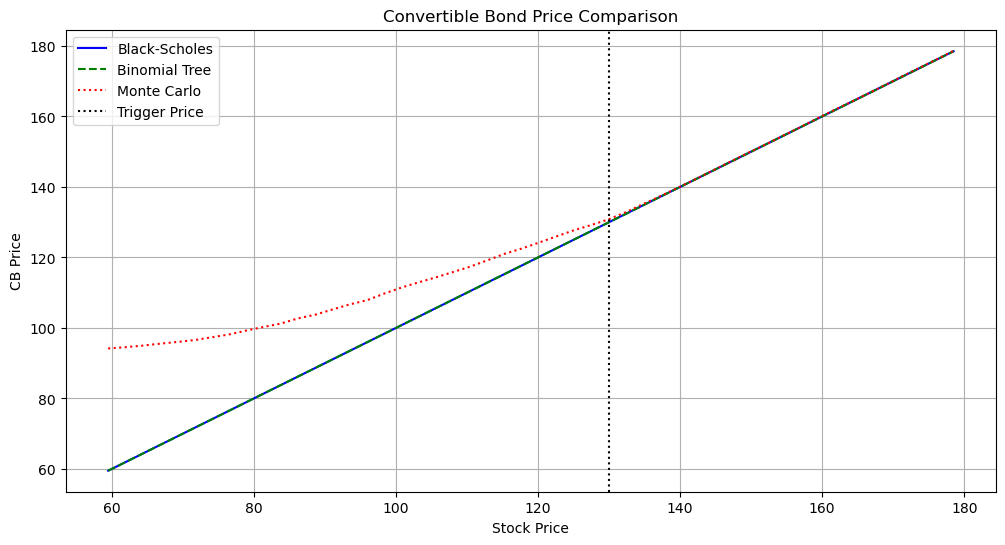

In [5]:
# 設定參數
S = 119  # 股票現價
K = 100  # 債券面額
T = 1    # 到期時間（年）
r = 0.05 # 無風險利率
sigma = 0.3  # 波動率
conversion_ratio = 1.0  # 轉換比率
credit_spread = 0.02  # 信用利差
trigger_price = 130  # 強制轉換觸發價格

pricer = ConvertibleBondPricer(S, K, T, r, sigma, conversion_ratio, 
                                credit_spread, trigger_price)

# 比較三種方法的結果
results = pricer.compare_methods()
for method, price in results.items():
    print(f"{method} Price: {price:.2f}")

# 繪製比較圖
pricer.plot_comparison()

In [7]:
# 讀取CB資料
path_cb = r'C:\Users\User\Desktop\CB-pricing\CB data\CB_mess.txt'
cb_df = pd.read_csv(path_cb, encoding='big5', sep='\t', encoding_errors='replace')
cb_df


C:\Users\User\AppData\Local\Temp\ipykernel_9208\4132290046.py:3: DtypeWarning: Columns (3,8,15,16,17,21,22,23,24,28,29,41) have mixed types. Specify dtype option on import or set low_memory=False.
  cb_df = pd.read_csv(path_cb, encoding='big5', sep='\t', encoding_errors='replace')


,公司代碼,簡稱,年月,最近一期轉換價格日,最近一期配股基準日,首次發行(Y/N),發行總額(1000),到目前餘額(1000),轉換價格,上市日,...,賣回價%(五),賣回收益率五,賣回日起(六),賣回日迄(六),賣回價%(六),賣回收益率六,賣回日起(七),賣回日迄(七),賣回價%(七),賣回收益率七
0,0AH781P,臺醫光電一(P),201910,20191018,2019/10/18,Y,10000,10000,2.7,,...,-,-,,,-,-,,,-,-
1,0AH781P,臺醫光電一(P),201911,20191018,2019/10/18,N,10000,10000,2.7,,...,-,-,,,-,-,,,-,-
2,0AH781P,臺醫光電一(P),201912,20191018,2019/10/18,N,10000,10000,2.7,,...,-,-,,,-,-,,,-,-
3,0AH781P,臺醫光電一(P),202001,20191018,2019/10/18,N,10000,10000,2.7,,...,-,-,,,-,-,,,-,-
4,0AH781P,臺醫光電一(P),202002,20191018,2019/10/18,N,10000,0,2.7,,...,-,-,,,-,-,,,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103715,Z55911P,富盛國際產業一(P),202411,20240715,2024/07/15,N,2000000,2000000,11.0000,,...,-,-,,,-,-,,,-,-
103716,Z55921P,以諾驛站一(P),202408,20240810,2024/08/10,Y,6000,6000,10.0000,,...,-,-,,,-,-,,,-,-
103717,Z55921P,以諾驛站一(P),202409,20240810,2024/08/10,N,6000,6000,10.0000,,...,-,-,,,-,-,,,-,-
103718,Z55921P,以諾驛站一(P),202410,20240810,2024/08/10,N,6000,6000,10.0000,,...,-,-,,,-,-,,,-,-


In [10]:
cb_df_6753 = cb_df[cb_df['公司代碼'].astype(str).str.contains('6753')]
cb_df_6753

,公司代碼,簡稱,年月,最近一期轉換價格日,最近一期配股基準日,首次發行(Y/N),發行總額(1000),到目前餘額(1000),轉換價格,上市日,...,賣回價%(五),賣回收益率五,賣回日起(六),賣回日迄(六),賣回價%(六),賣回收益率六,賣回日起(七),賣回日迄(七),賣回價%(七),賣回收益率七
91480,67531,龍德造船一,202406,20240625,2024/06/25,Y,1000000,1000000,125.0,20240625,...,-,-,,,-,-,,,-,-
91481,67531,龍德造船一,202407,20240625,2024/06/25,N,1000000,1000000,125.0,20240625,...,-,-,,,-,-,,,-,-
91482,67531,龍德造船一,202408,20240625,2024/06/25,N,1000000,1000000,125.0,20240625,...,-,-,,,-,-,,,-,-
91483,67531,龍德造船一,202409,20240901,2024/09/01,N,1000000,1000000,117.9,20240625,...,-,-,,,-,-,,,-,-
91484,67531,龍德造船一,202410,20240901,2024/09/01,N,1000000,1000000,117.9,20240625,...,-,-,,,-,-,,,-,-
91485,67531,龍德造船一,202411,20240901,2024/09/01,N,1000000,1000000,117.9,20240625,...,-,-,,,-,-,,,-,-


In [15]:
cb_df_2610 = cb_df[(cb_df['公司代碼'].astype(str).str.contains('2610')) & (cb_df['首次發行(Y/N)'] != 'Y')]
cb_df_2610.to_csv('cb_2610_test.csv')

In [ ]:
is_StrikePriceTouch = cb_df['轉換否 (Y/N)']
is_StrikePriceTouch

0         Y
1         Y
2         Y
3         Y
4         Y
         ..
103715    Y
103716    Y
103717    Y
103718    Y
103719    Y
Name: 轉換否 (Y/N), Length: 103720, dtype: object

In [ ]:
# 假設原資料是一個 Series
data = is_StrikePriceTouch

# 將 'Y' 和 'N' 轉換為 1 和 0
數值 = data.map({'Y': 1, 'N': 0})

# 計算累積 Y 次數
累積Y次數 = 數值.cumsum()

# 計算機率分配
機率分配 = 數值.value_counts(normalize=True)

# 顯示結果
結果 = pd.DataFrame({
    '轉換否 (Y/N)': data,
    '數值': 數值,
    '累積Y次數': 累積Y次數
})

print("數據的累積 Y 次數：")
print(結果)
print("\n機率分配：")
print(機率分配)



數據的累積 Y 次數：
       轉換否 (Y/N)   數值     累積Y次數
0              Y  1.0       1.0
1              Y  1.0       2.0
2              Y  1.0       3.0
3              Y  1.0       4.0
4              Y  1.0       5.0
...          ...  ...       ...
103715         Y  1.0  103684.0
103716         Y  1.0  103685.0
103717         Y  1.0  103686.0
103718         Y  1.0  103687.0
103719         Y  1.0  103688.0

[103720 rows x 3 columns]

機率分配：
轉換否 (Y/N)
1.0    1.0
Name: proportion, dtype: float64


In [ ]:
# 使用 value_counts() 方法計算 'Y' 的數量
y_count = data.value_counts().get('Y', 0)

print(f"Y 的數量: {y_count}")

Y 的數量: 103688
